References:
- https://www.kaggle.com/code/ashishpatel26/gan-beginner-tutorial-for-pytorch-celeba-dataset


### Import packages

In [1]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader, Subset, SequentialSampler
import matplotlib.pyplot as plt
%matplotlib inline

### Hyperparameters

In [6]:
image_size = 80
batch_size_train = 100
batch_size_val = 1000
num_workers = 0
shuffle_loader = True
root = 'datasets/'
TARGET_ATTR = 'Eyeglasses' #'Wearing_Hat', 'Bald', 'Bangs', 'Eyeglasses', 'Male', 'No_Beard', 'Smiling', 'Young', 

In [7]:
ATTR = "5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young"
ATTR = {attr: attr_idx for attr_idx, attr in enumerate(ATTR.split(' '))}
target_attr_index = ATTR[TARGET_ATTR]
target_attr_index

15

### Load Dataset & Create dataloader

In [4]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

order = list(range(160000))
# import random
# random.seed(0)
# random.shuffle(order)

dataset_train = Subset(CelebA(root=root, split='train', transform=transform, target_type='attr', download=False), order)
# dataset_val = CelebA(root=root, split='valid', transform=transform, target_type='attr', download=False)
dataset_val = CelebA(root=root, split='valid', transform=transform, target_type='attr', download=False)

In [5]:
loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, shuffle=shuffle_loader, num_workers=num_workers, drop_last=False)
loader_val = DataLoader(dataset=dataset_val, batch_size=batch_size_val, shuffle=False, num_workers=num_workers, drop_last=False)

In [8]:
attr_true_list_train = []
attr_false_list_train = []
cnt = [15, 15]
for i, (im, lab) in enumerate(loader_train):
    for j, l in enumerate(lab[...,target_attr_index]):
        if l==1 and cnt[1] > 0:
            attr_true_list_train.append(j)
            cnt[1] -= 1
        elif l==0 and cnt[0] > 0:
            attr_false_list_train.append(j)
            cnt[0] -= 1
    if sum(cnt) == 0 : break
print(attr_true_list_train)
print(attr_false_list_train)

[8, 27, 65, 66, 77, 92, 21, 43, 47, 52, 61, 70, 91, 16, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15]


In [9]:
attr_true_list_val = []
attr_false_list_val = []
cnt = [15, 15]
for i, (im, lab) in enumerate(loader_val):
    for j, l in enumerate(lab[...,target_attr_index]):
        if l==1 and cnt[1] > 0:
            attr_true_list_val.append(j)
            cnt[1] -= 1
        elif l==0 and cnt[0] > 0:
            attr_false_list_val.append(j)
            cnt[0] -= 1
    if sum(cnt) == 0 : break
print(attr_true_list_val)
print(attr_false_list_val)

[15, 25, 36, 45, 62, 74, 96, 105, 114, 118, 126, 128, 136, 162, 167]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [10]:
len(dataset_train), len(dataset_val)

(160000, 19867)

### Example of visualization

tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1])
torch.Size([100, 1, 80, 80])


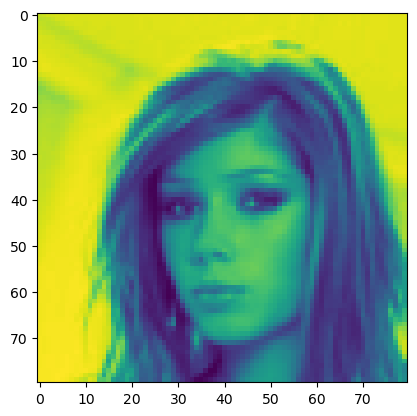

In [11]:
denorm = transforms.Normalize((-1,),(2,))

def im_show(img, ax=None):
    img_denorm = denorm(img)
    img_t = torch.permute(img_denorm, (1,2,0))
    img_t.clamp_(0, 1)
    if ax is not None:
        ax.imshow(img_t)
    else:
        plt.imshow(img_t)

img_example, label_example = next(iter(loader_train))

im_show(img_example[0])
print(label_example[0])
print(img_example.shape)

In [12]:
from tqdm.auto import tqdm
def comparison_figure(pca, dataset, indices, save_name):
    fig, axes = plt.subplots(2, len(indices), figsize=(2.6*len(indices), 5))
    
    for i, img_ind in tqdm(enumerate(indices)):
        img, _ = dataset[img_ind]
        projected = pca.transform(img).cpu()
        im_show(img, axes[0][i])
        im_show(projected[0], axes[1][i])
        axes[0][i].axis('off')
        axes[1][i].axis('off')

    axes[0][0].set_ylabel('Original')
    axes[1][0].set_ylabel('Results')
    fig.tight_layout(pad=0)
    fig.savefig(os.path.join('figures',save_name))

### Run PCA - Vanilla

In [23]:
from fair_streaming_pca_pytorch import FairStreamingPCA

pca_vanilla = FairStreamingPCA(TARGET_ATTR, device='mps')
pca_vanilla.fit(
    loader=loader_train,
    target_unfair_dim=1,
    target_pca_dim=1000,
    n_iter_unfair=5,
    n_iter_pca=10,
    block_size_unfair=1600,
    block_size_pca=160,
    constraint='vanilla',
    unfairness_frequent_direction=True,
    verbose=False,
    seed=0,
    save_V=True
)

pca_vanilla.transform(loader=loader_val)
print("Exp Var Ratio:", pca_vanilla.explained_variance_ratio)
print("Exp Var Ratio - Group 0:", pca_vanilla.explained_variance_ratio_group[0])
print("Exp Var Ratio - Group 1:", pca_vanilla.explained_variance_ratio_group[1])
print("Exp Var Ratio Difference:", pca_vanilla.explained_variance_ratio_group[0] - pca_vanilla.explained_variance_ratio_group[1])

PCA::   0%|          | 0/10 [00:00<?, ?it/s]

Evaluation::   0%|          | 0/20 [00:00<?, ?it/s]

Exp Var Ratio: 0.9452531739192586
Exp Var Ratio - Group 0: 0.9457025494869074
Exp Var Ratio - Group 1: 0.939206432839364
Exp Var Ratio Difference: 0.0064961166475433485


tensor(False)


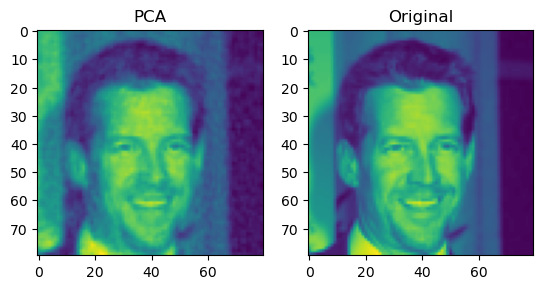

In [14]:
img_example, label_example = next(iter(loader_val))
index = 14
print(label_example[index][pca_vanilla.a]==1)
projected = pca_vanilla.transform(img_example[index]).cpu()
fig, ax = plt.subplots(1,2)
im_show(projected[0], ax[0])
im_show(img_example[index], ax[1])
ax[0].title.set_text('PCA')
ax[1].title.set_text('Original')
fig.savefig('out_vanilla.pdf')

### Run PCA - Mean

In [15]:
from fair_streaming_pca_pytorch import FairStreamingPCA

pca_mean = FairStreamingPCA(TARGET_ATTR, device='cpu')
pca_mean.fit(
    loader=loader_train,
    target_unfair_dim=1,
    target_pca_dim=1000,
    n_iter_unfair=100,
    n_iter_pca=100,
    block_size_unfair=1600,
    block_size_pca=1600,
    constraint='mean',
    unfairness_frequent_direction=False,
    verbose=False,
    seed=0,
    save_V=True
)

pca_mean.transform(loader=loader_val,)
print("Exp Var Ratio:", pca_mean.explained_variance_ratio)
print("Exp Var Ratio - Group 0:", pca_mean.explained_variance_ratio_group[0])
print("Exp Var Ratio - Group 1:", pca_mean.explained_variance_ratio_group[1])
print("Exp Var Ratio Difference:", pca_mean.explained_variance_ratio_group[0] - pca_mean.explained_variance_ratio_group[1])

UnfairEstim::   0%|          | 0/100 [00:00<?, ?it/s]

PCA::   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation::   0%|          | 0/20 [00:00<?, ?it/s]

Exp Var Ratio: 0.9617716293903316
Exp Var Ratio - Group 0: 0.9605681627885626
Exp Var Ratio - Group 1: 0.9766608433971695
Exp Var Ratio Difference: -0.016092680608606913


tensor(False)


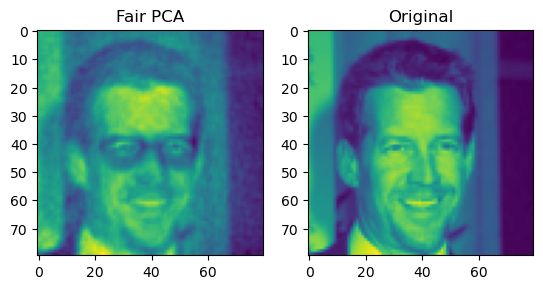

In [16]:
img_example, label_example = next(iter(loader_val))
index = 14
print(label_example[index][pca_mean.a]==1)
projected = pca_mean.transform(img_example[index]).cpu()
fig, ax = plt.subplots(1,2)
im_show(projected[0], ax[0])
im_show(img_example[index], ax[1])
ax[0].title.set_text('Fair PCA')
ax[1].title.set_text('Original')
fig.savefig('out_mean.pdf')

In [ ]:
# algo = 'fairMean'
# style = 'gray8080'
# comparison_figure(pca_mean, dataset_train, attr_true_list_train, f'{style}_{TARGET_ATTR}_{algo}_train_true.pdf')
# comparison_figure(pca_mean, dataset_train, attr_false_list_train, f'{style}_{TARGET_ATTR}_{algo}_train_false.pdf')
# comparison_figure(pca_mean, dataset_val, attr_true_list_val, f'{style}_{TARGET_ATTR}_{algo}_val_true.pdf')
# comparison_figure(pca_mean, dataset_val, attr_false_list_val, f'{style}_{TARGET_ATTR}_{algo}_val_false.pdf')

### Run PCA - Covariance

In [64]:
# from fair_streaming_pca_pytorch import FairStreamingPCA import

# pca_cov = FairStreamingPCA(TARGET_ATTR)
# pca_cov.fit(
#     loader=loader_train,
#     target_unfair_dim=1,
#     target_pca_dim=400,
#     n_iter_unfair=11,
#     n_iter_pca=11,
#     block_size_unfair=20000,
#     block_size_pca=20000,
#     constraint='covariance',
#     unfairness_frequent_direction=False,
#     verbose=False
# )

# img_example, label_example = next(iter(loader_val))
# index = 14
# projected = pca_cov.transform(img_example[index], lambda_transform=lambda x: torch.Tensor(np.asarray(x)))
# fig, ax = plt.subplots(1,2)
# im_show(projected[0], ax[0])
# im_show(img_example[index], ax[1])
# ax[0].title.set_text('PCA')
# ax[1].title.set_text('Original')

# pca_cov.transform(loader=loader_val,)
# mmd_cov = pca_cov.maximum_mean_discrepancy
# print("Exp Var Ratio:", pca_cov.explained_variance_ratio)
# print("Exp Var Ratio - Group 0:", pca_cov.explained_variance_ratio_group[0])
# print("Exp Var Ratio - Group 1:", pca_cov.explained_variance_ratio_group[1])
# print("MMD score:", pca_cov.maximum_mean_discrepancy)
# print("MMD score decreased by", mmd_vanilla - mmd_cov)

### Run PCA - All

In [17]:
from fair_streaming_pca_pytorch import FairStreamingPCA

pca_all = FairStreamingPCA(TARGET_ATTR, device='cpu')
pca_all.fit(
    loader=loader_train,
    target_unfair_dim=2,
    target_pca_dim=1000,
    n_iter_unfair=100,
    n_iter_pca=100,
    block_size_unfair=1600,
    block_size_pca=1600,
    constraint='all',
    unfairness_frequent_direction=False,
    verbose=False,
    seed=0,
    save_V=True
)

pca_all.transform(loader=loader_val,)
print("Exp Var Ratio:", pca_all.explained_variance_ratio)
print("Exp Var Ratio - Group 0:", pca_all.explained_variance_ratio_group[0])
print("Exp Var Ratio - Group 1:", pca_all.explained_variance_ratio_group[1])
print("Exp Var Ratio Difference:", pca_all.explained_variance_ratio_group[0] - pca_all.explained_variance_ratio_group[1])

UnfairEstim::   0%|          | 0/100 [00:00<?, ?it/s]

PCA::   0%|          | 0/100 [00:00<?, ?it/s]

Evaluation::   0%|          | 0/20 [00:00<?, ?it/s]

Exp Var Ratio: 0.8266708723472806
Exp Var Ratio - Group 0: 0.8256891583388978
Exp Var Ratio - Group 1: 0.8391475670163561
Exp Var Ratio Difference: -0.013458408677458289


tensor(False)


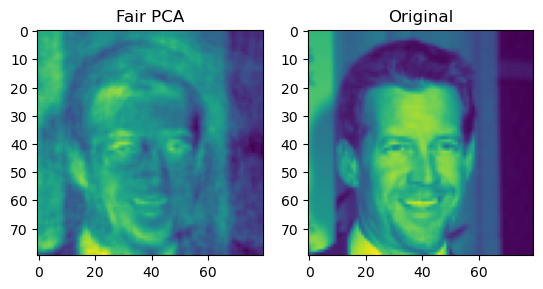

In [18]:
img_example, label_example = next(iter(loader_val))
index = 14
print(label_example[index][pca_all.a]==1)
projected = pca_all.transform(img_example[index]).cpu()
fig, ax = plt.subplots(1,2)
im_show(projected[0], ax[0])
im_show(img_example[index], ax[1])
ax[0].title.set_text('Fair PCA')
ax[1].title.set_text('Original')
fig.savefig('out_all_{}.pdf')

In [ ]:
# algo = 'fairAll1'
# style = 'gray8080'
# comparison_figure(pca_all, dataset_train, attr_true_list_train, f'{style}_{TARGET_ATTR}_{algo}_train_true.pdf')
# comparison_figure(pca_all, dataset_train, attr_false_list_train, f'{style}_{TARGET_ATTR}_{algo}_train_false.pdf')
# comparison_figure(pca_all, dataset_val, attr_true_list_val, f'{style}_{TARGET_ATTR}_{algo}_val_true.pdf')
# comparison_figure(pca_all, dataset_val, attr_false_list_val, f'{style}_{TARGET_ATTR}_{algo}_val_false.pdf')

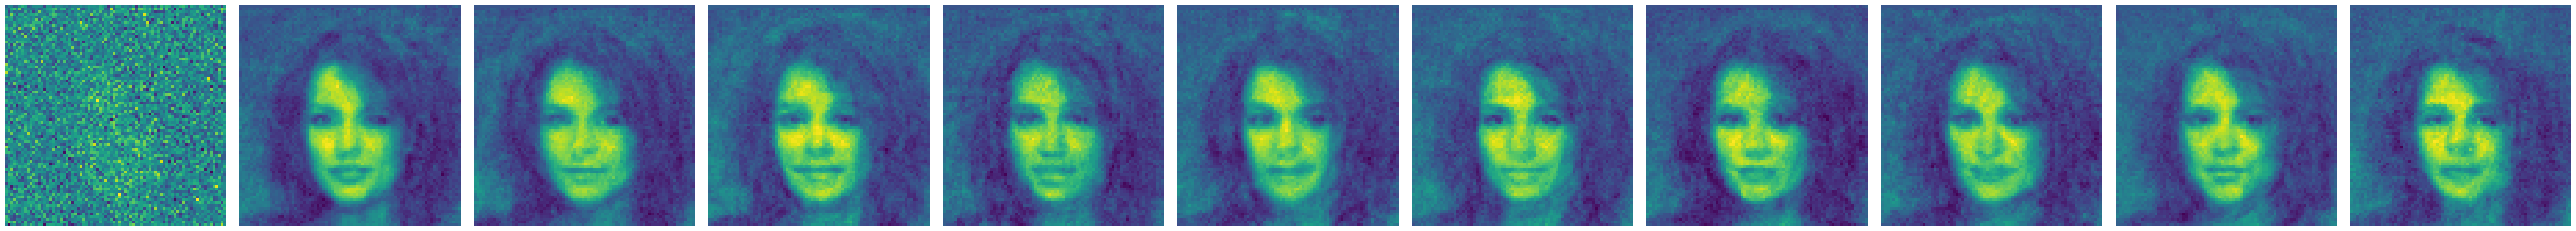

In [24]:
img_example, label_example = next(iter(loader_val))
index = 0
buffer_V = pca_vanilla.buffer_V
fig, axes = plt.subplots(1, len(buffer_V), figsize=(5*len(buffer_V), 5))
for ax, V in zip(axes, buffer_V):
    ax.axis('off')
    pca_vanilla.V = V
    projected = pca_vanilla.transform(img_example[index]).cpu()
    im_show(projected[0], ax)
fig.tight_layout()
fig.savefig('vanilla_over_time.pdf')

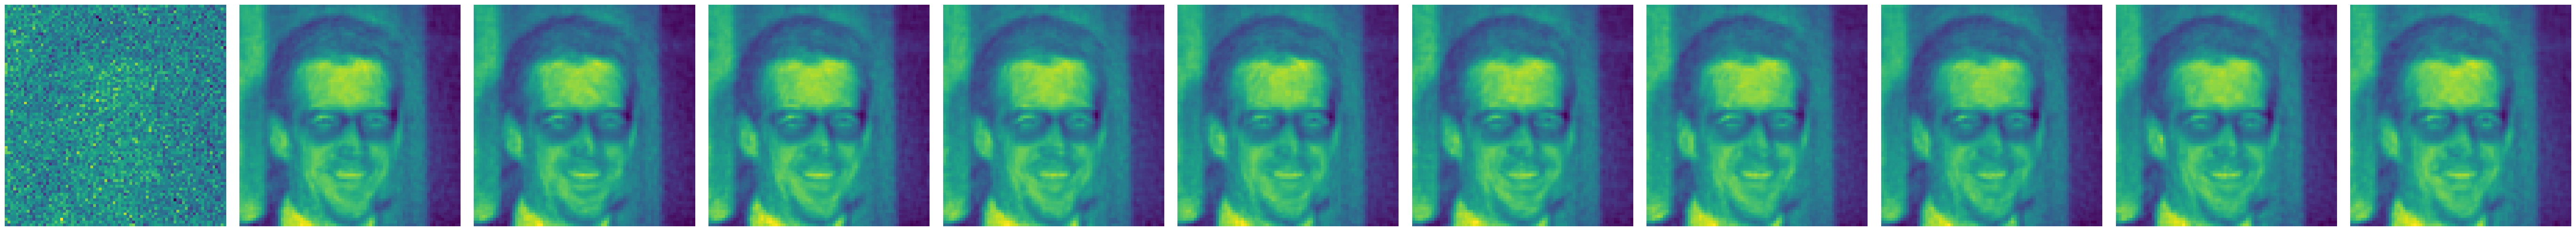

In [20]:
img_example, label_example = next(iter(loader_val))
index = 14
buffer_V = pca_mean.buffer_V
fig, axes = plt.subplots(1, len(buffer_V), figsize=(5*len(buffer_V), 5))
for ax, V in zip(axes, buffer_V):
    ax.axis('off')
    pca_mean.V = V
    projected = pca_mean.transform(img_example[index]).cpu()
    im_show(projected[0], ax)
fig.tight_layout()
fig.savefig('mean_over_time.pdf')

tensor(0)


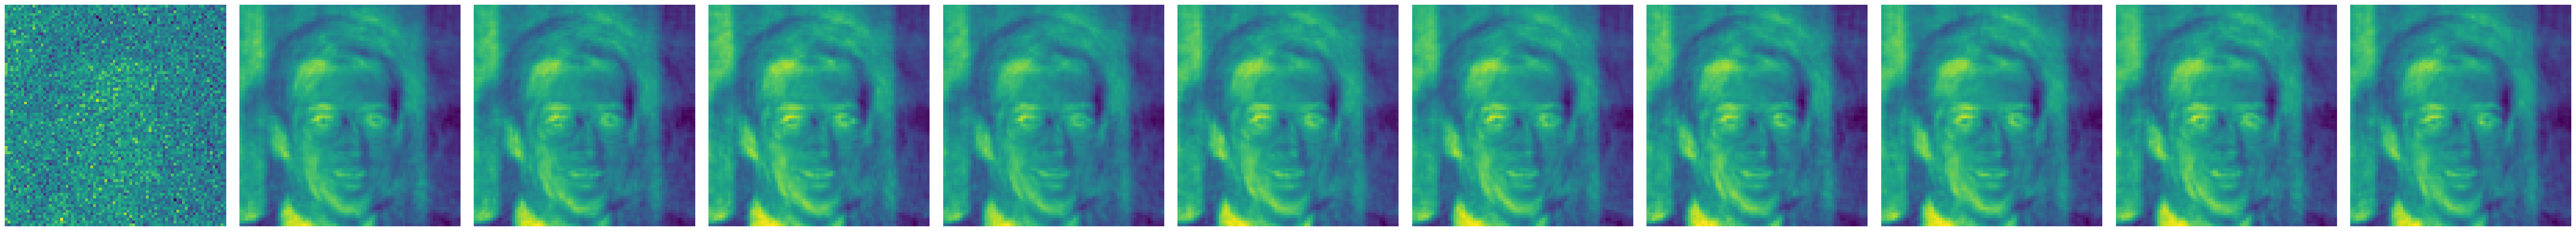

In [22]:
img_example, label_example = next(iter(loader_val))
index = 14
print(label_example[index][pca_all.a])
buffer_V = pca_all.buffer_V
fig, axes = plt.subplots(1, len(buffer_V), figsize=(5*len(buffer_V), 5))
for ax, V in zip(axes, buffer_V):
    ax.axis('off')
    pca_all.V = V
    projected = pca_all.transform(img_example[index]).cpu()
    im_show(projected[0], ax)
fig.tight_layout()
fig.savefig('all_over_time.pdf')

### Run PCA - Kleindessner

In [25]:
from fair_streaming_pca_pytorch import FairStreamingPCA

pca_offline = FairStreamingPCA(TARGET_ATTR, device='cpu')
pca_offline.fit_offline(
    loader=loader_train,
    target_unfair_dim=None,
    target_pca_dim=2,
    constraint='vanilla',
)

pca_offline.transform(loader=loader_val,)
print("Exp Var Ratio:", pca_offline.explained_variance_ratio)
print("Exp Var Ratio - Group 0:", pca_offline.explained_variance_ratio_group[0])
print("Exp Var Ratio - Group 1:", pca_offline.explained_variance_ratio_group[1])
print("Exp Var Ratio Difference:", pca_offline.explained_variance_ratio_group[0] - pca_offline.explained_variance_ratio_group[1])

Data Collection::   0%|          | 0/160 [00:00<?, ?it/s]

PCA...
Covariance Size: torch.Size([1, 6400, 6400])


Evaluation::   0%|          | 0/20 [00:00<?, ?it/s]

Exp Var Ratio: 0.665683830973066
Exp Var Ratio - Group 0: 0.6525317574427144
Exp Var Ratio - Group 1: 0.6821836070420754
Exp Var Ratio Difference: -0.029651849599360958


  0%|          | 0/20 [00:00<?, ?it/s]

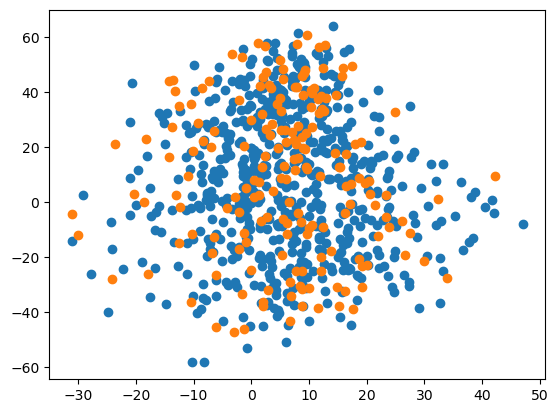

In [28]:
channel = 0
X, Y = [[], []], [[], []]
for img, label in tqdm(loader_val):
    ss = label[pca_offline.a]
    img_transformed = pca_offline.transform_low_dimension(img) # b, c, k
    img_transformed = img_transformed[:,channel]  # pick one channel
    for (x, y), s in zip(img_transformed, ss):
        X[s.item()].append(x.item())
        Y[s.item()].append(y.item())

plt.scatter(X[0],Y[0], label='No')
plt.scatter(X[1],Y[1], label='Yes')

tensor(False)


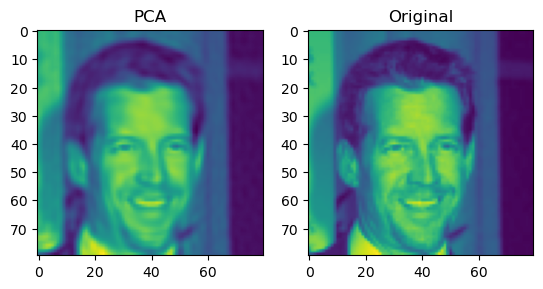

In [72]:
img_example, label_example = next(iter(loader_val))
index = 14
print(label_example[index][pca_offline.a]==1)
projected = pca_offline.transform(img_example[index]).cpu()
fig, ax = plt.subplots(1,2)
im_show(projected[0], ax[0])
im_show(img_example[index], ax[1])
ax[0].title.set_text('PCA')
ax[1].title.set_text('Original')
fig.savefig('out_kleindessener_vanilla.pdf')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

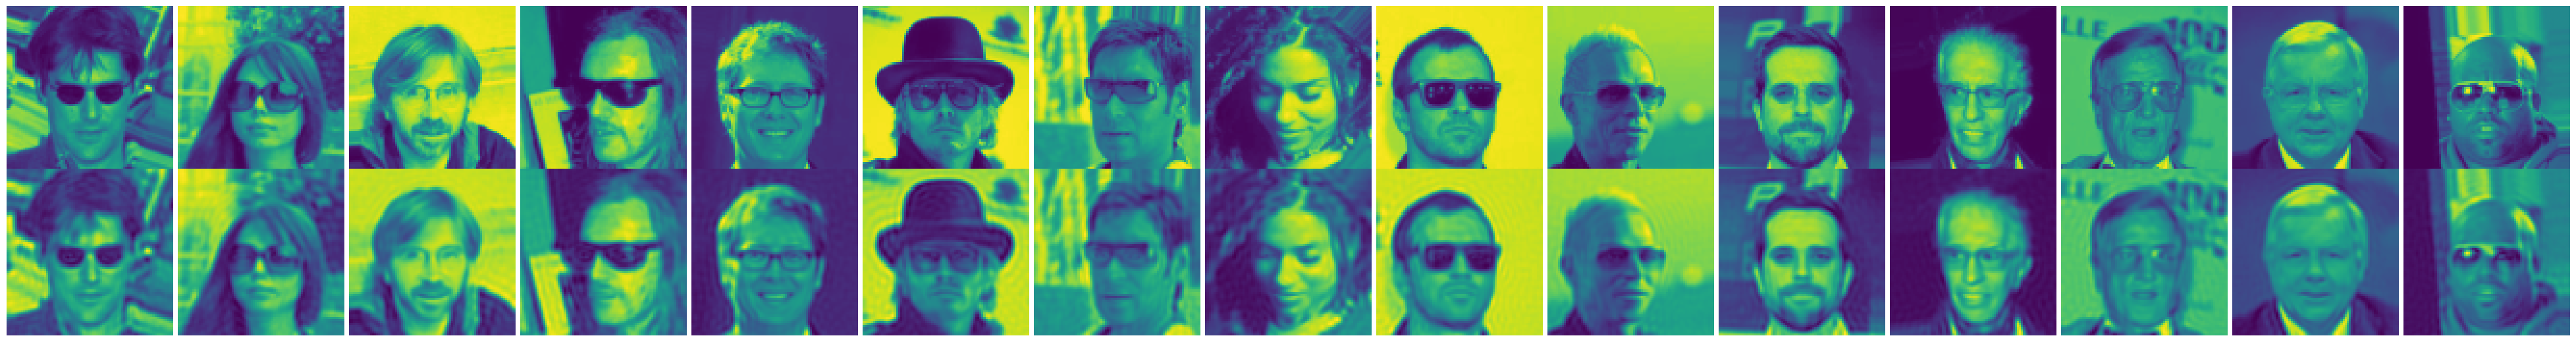

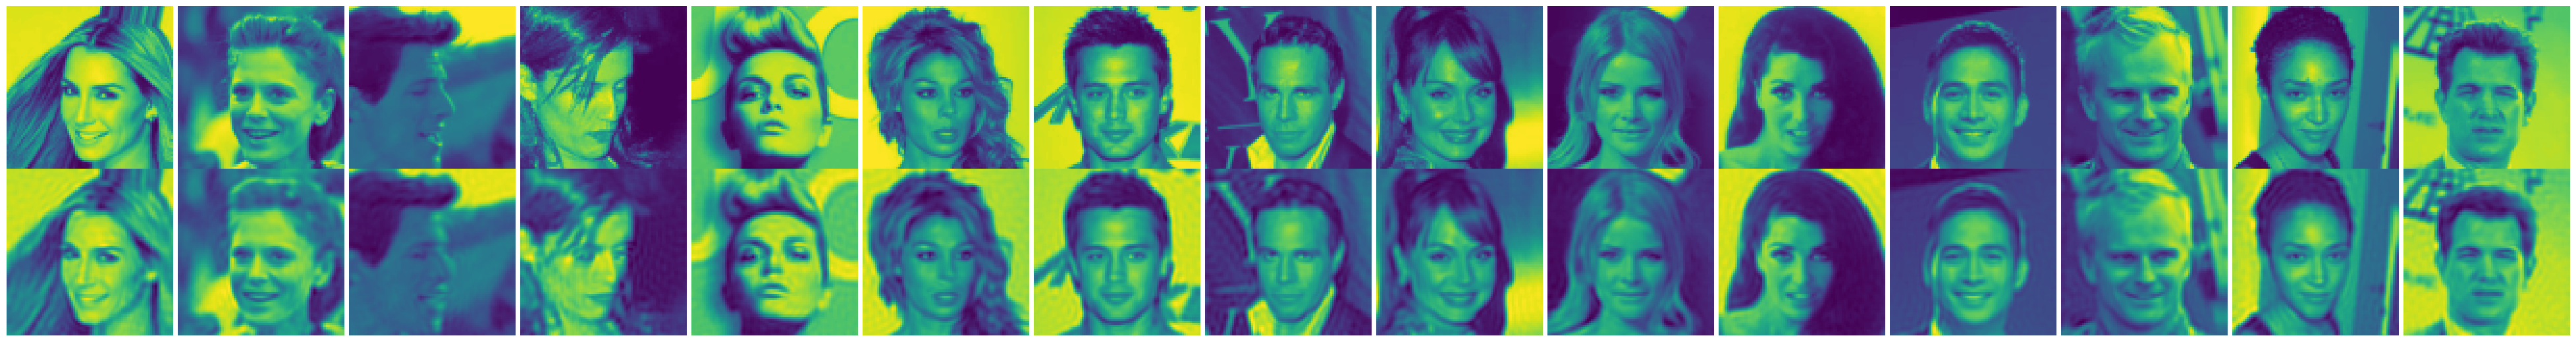

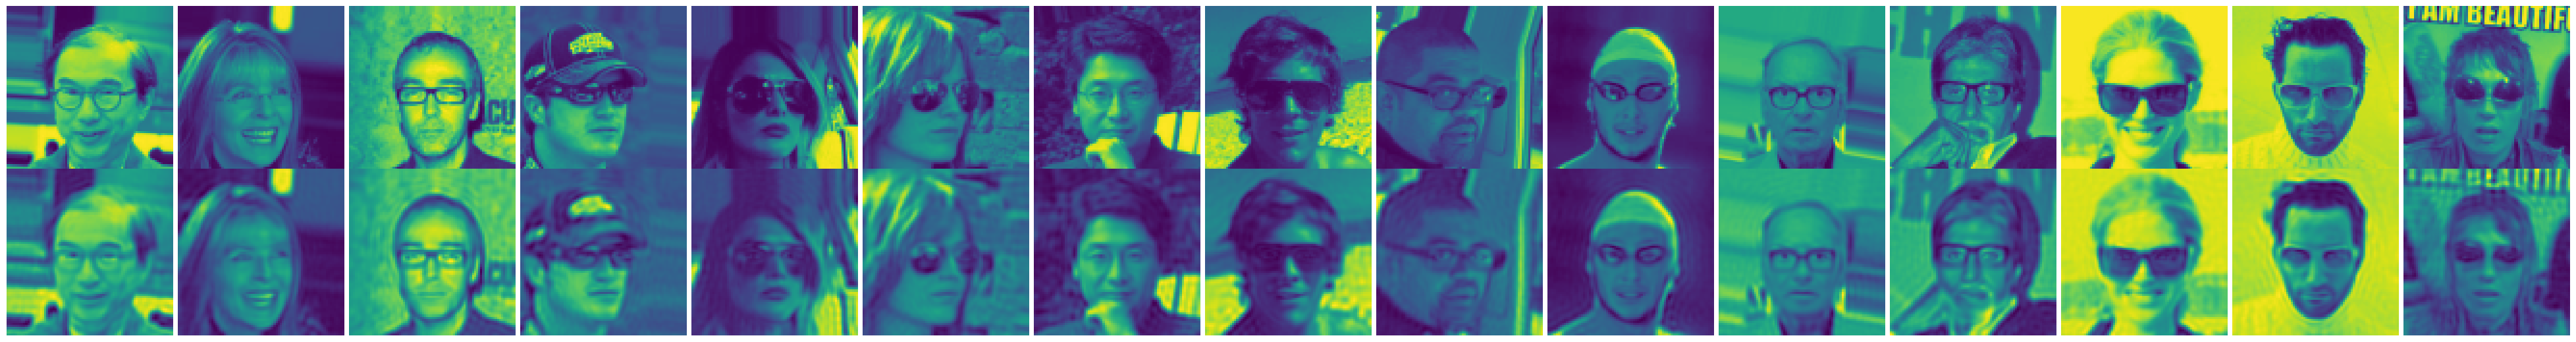

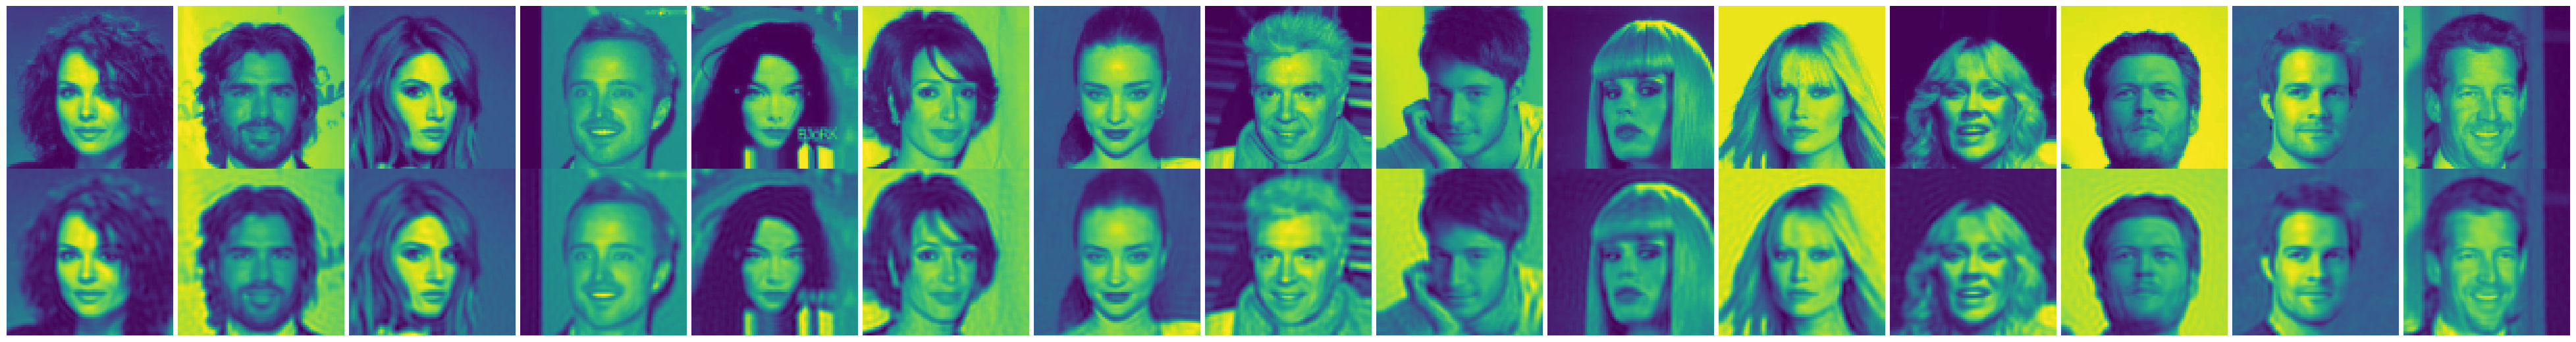

In [73]:
algo = 'fairVanillaOffline'
style = 'gray8080'
comparison_figure(pca_offline, dataset_train, attr_true_list_train, f'{style}_{TARGET_ATTR}_{algo}_train_true.pdf')
comparison_figure(pca_offline, dataset_train, attr_false_list_train, f'{style}_{TARGET_ATTR}_{algo}_train_false.pdf')
comparison_figure(pca_offline, dataset_val, attr_true_list_val, f'{style}_{TARGET_ATTR}_{algo}_val_true.pdf')
comparison_figure(pca_offline, dataset_val, attr_false_list_val, f'{style}_{TARGET_ATTR}_{algo}_val_false.pdf')

In [11]:
from fair_streaming_pca_pytorch import FairStreamingPCA

pca_offline = FairStreamingPCA(TARGET_ATTR, device='cpu')
pca_offline.fit_offline(
    loader=loader_train,
    target_unfair_dim=None,
    target_pca_dim=1000,
    constraint='mean',
)

pca_offline.transform(loader=loader_val,)
print("Exp Var Ratio:", pca_offline.explained_variance_ratio)
print("Exp Var Ratio - Group 0:", pca_offline.explained_variance_ratio_group[0])
print("Exp Var Ratio - Group 1:", pca_offline.explained_variance_ratio_group[1])
print("Exp Var Ratio Difference:", pca_offline.explained_variance_ratio_group[0] - pca_offline.explained_variance_ratio_group[1])

Data Collection::   0%|          | 0/160 [00:00<?, ?it/s]

mean matching...
PCA...
Covariance Size: torch.Size([1, 6399, 6399])


Evaluation::   0%|          | 0/20 [00:00<?, ?it/s]

Exp Var Ratio: 0.9629965721885841
Exp Var Ratio - Group 0: 0.961688160232021
Exp Var Ratio - Group 1: 0.9792385019862988
Exp Var Ratio Difference: -0.01755034175427783


tensor(False)


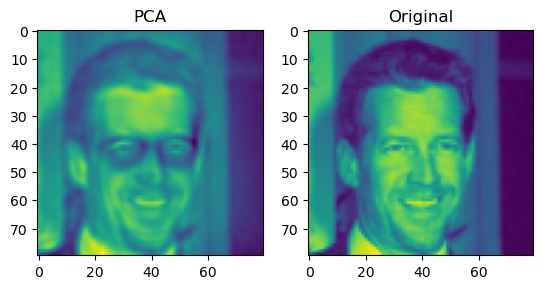

In [12]:
img_example, label_example = next(iter(loader_val))
index = 14
print(label_example[index][pca_offline.a]==1)
projected = pca_offline.transform(img_example[index]).cpu()
fig, ax = plt.subplots(1,2)
im_show(projected[0], ax[0])
im_show(img_example[index], ax[1])
ax[0].title.set_text('PCA')
ax[1].title.set_text('Original')
fig.savefig('out_kleindessener_mean.pdf')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

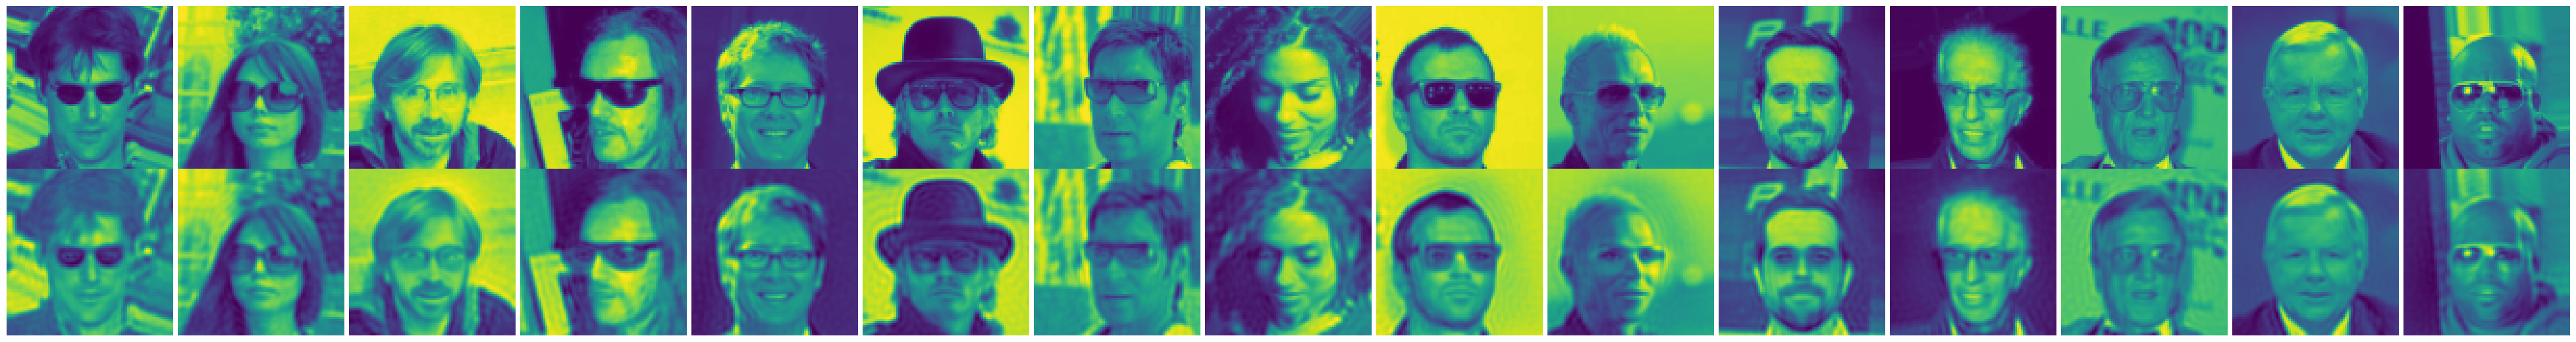

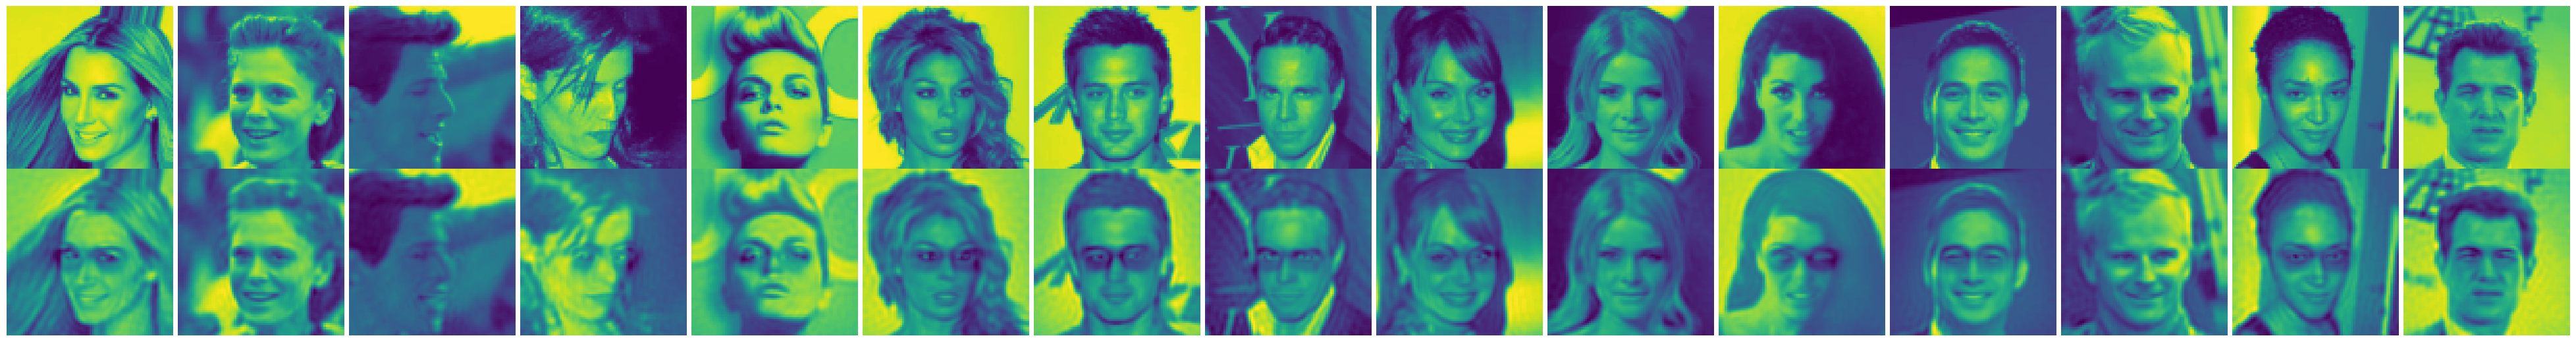

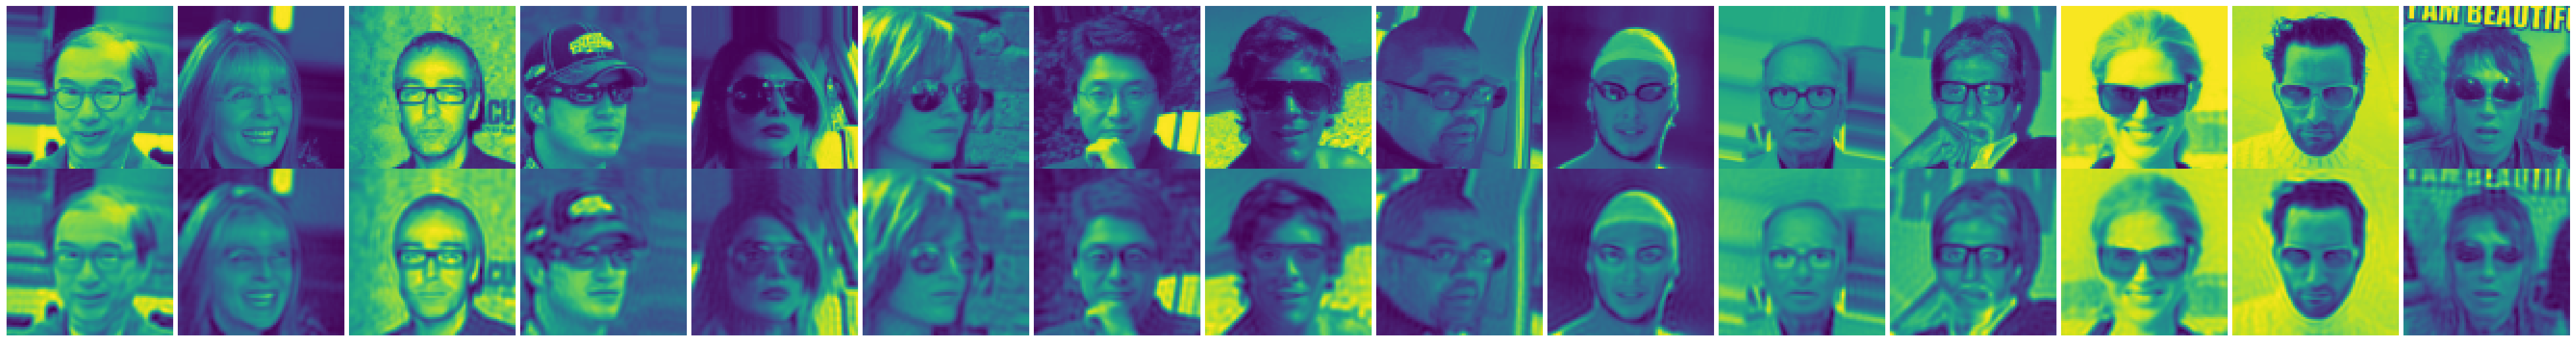

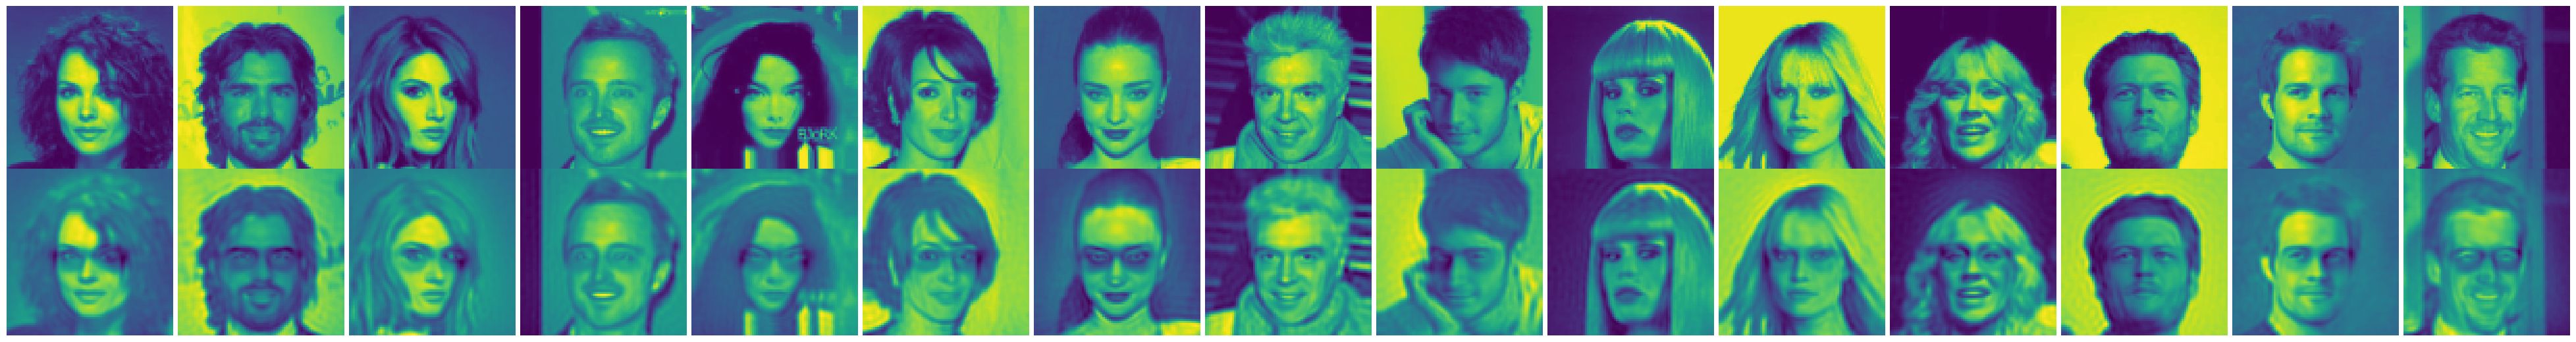

In [13]:
algo = 'fairMeanOffline'
style = 'gray8080'
comparison_figure(pca_offline, dataset_train, attr_true_list_train, f'{style}_{TARGET_ATTR}_{algo}_train_true.pdf')
comparison_figure(pca_offline, dataset_train, attr_false_list_train, f'{style}_{TARGET_ATTR}_{algo}_train_false.pdf')
comparison_figure(pca_offline, dataset_val, attr_true_list_val, f'{style}_{TARGET_ATTR}_{algo}_val_true.pdf')
comparison_figure(pca_offline, dataset_val, attr_false_list_val, f'{style}_{TARGET_ATTR}_{algo}_val_false.pdf')

In [14]:
from fair_streaming_pca_pytorch import FairStreamingPCA

pca_offline = FairStreamingPCA(TARGET_ATTR, device='cpu')
pca_offline.fit_offline(
    loader=loader_train,
    target_unfair_dim=1,
    target_pca_dim=1000,
    constraint='all',
)

pca_offline.transform(loader=loader_val,)
print("Exp Var Ratio:", pca_offline.explained_variance_ratio)
print("Exp Var Ratio - Group 0:", pca_offline.explained_variance_ratio_group[0])
print("Exp Var Ratio - Group 1:", pca_offline.explained_variance_ratio_group[1])
print("Exp Var Ratio Difference:", pca_offline.explained_variance_ratio_group[0] - pca_offline.explained_variance_ratio_group[1])

Data Collection::   0%|          | 0/160 [00:00<?, ?it/s]

mean matching...
covariance matching...
PCA...
Covariance Size: torch.Size([1, 6398, 6398])


Evaluation::   0%|          | 0/20 [00:00<?, ?it/s]

Exp Var Ratio: 0.8055964216538174
Exp Var Ratio - Group 0: 0.8067617781252294
Exp Var Ratio - Group 1: 0.7902536679676109
Exp Var Ratio Difference: 0.01650811015761855


tensor(False)


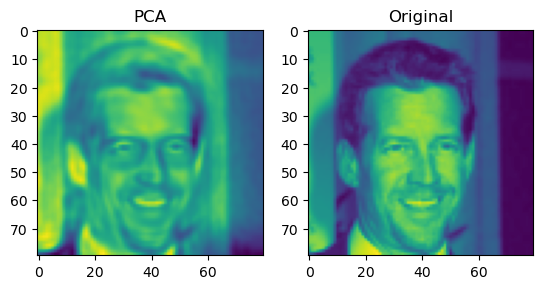

In [15]:
img_example, label_example = next(iter(loader_val))
index = 14
print(label_example[index][pca_offline.a]==1)
projected = pca_offline.transform(img_example[index]).cpu()
fig, ax = plt.subplots(1,2)
im_show(projected[0], ax[0])
im_show(img_example[index], ax[1])
ax[0].title.set_text('PCA')
ax[1].title.set_text('Original')
fig.savefig('out_kleindessener_all.pdf')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

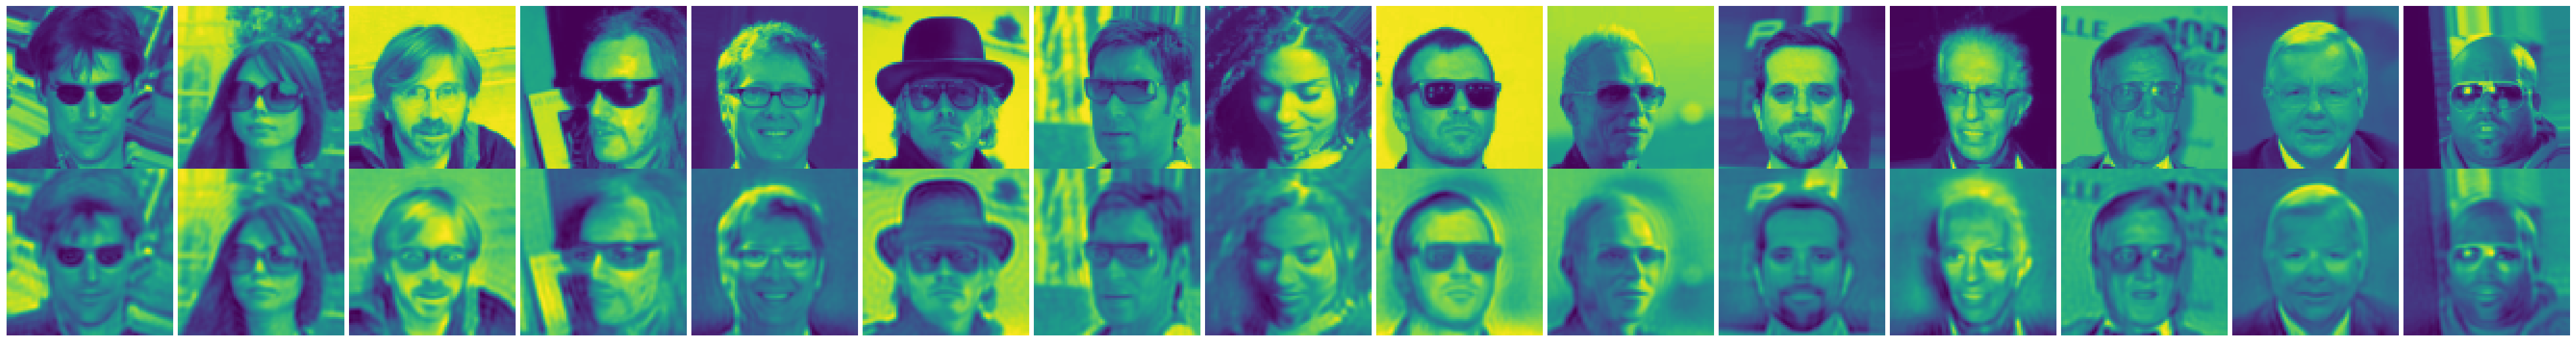

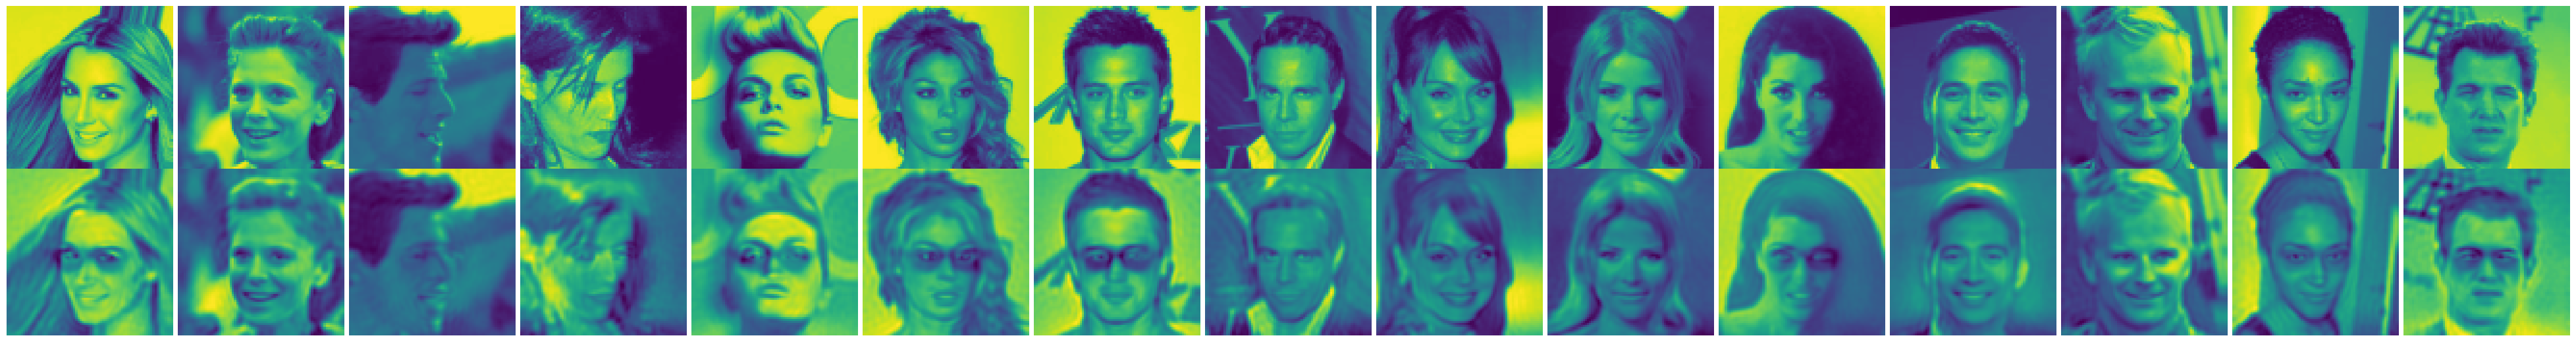

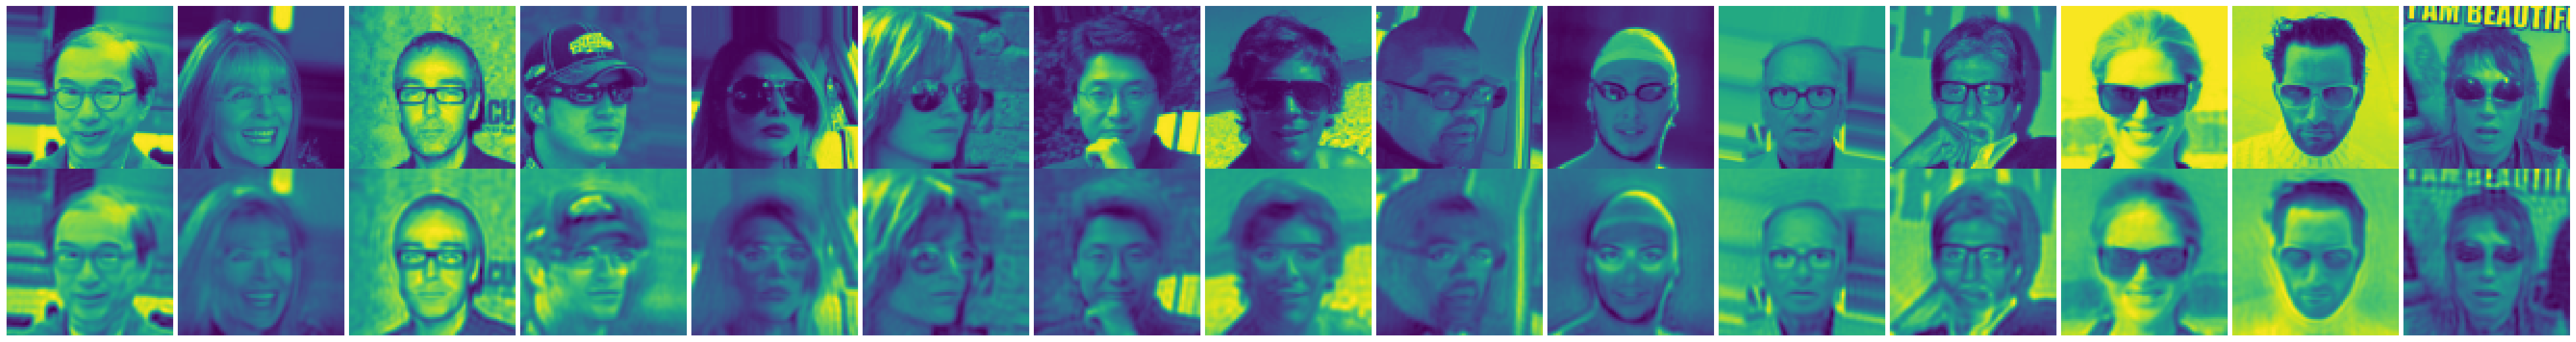

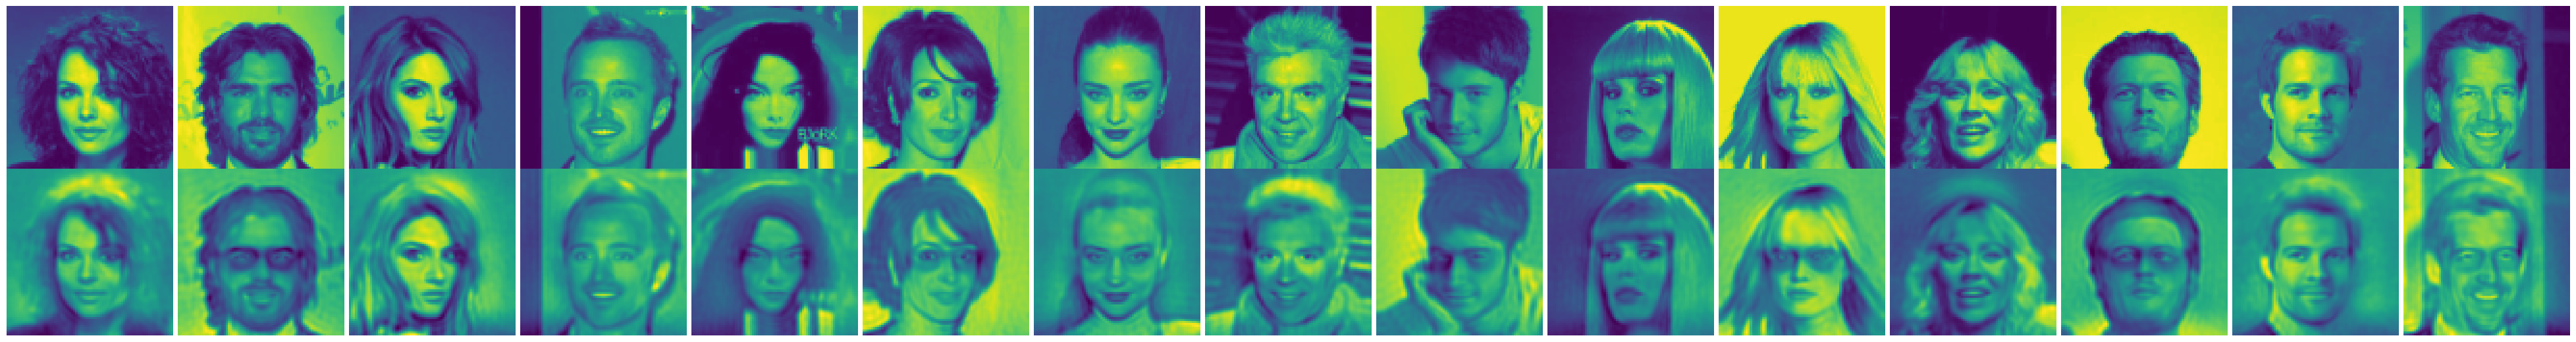

In [16]:
algo = 'fairAllOffline'
style = 'gray8080'
comparison_figure(pca_offline, dataset_train, attr_true_list_train, f'{style}_{TARGET_ATTR}_{algo}_train_true.pdf')
comparison_figure(pca_offline, dataset_train, attr_false_list_train, f'{style}_{TARGET_ATTR}_{algo}_train_false.pdf')
comparison_figure(pca_offline, dataset_val, attr_true_list_val, f'{style}_{TARGET_ATTR}_{algo}_val_true.pdf')
comparison_figure(pca_offline, dataset_val, attr_false_list_val, f'{style}_{TARGET_ATTR}_{algo}_val_false.pdf')

In [26]:
from tqdm.auto import tqdm
b = [0, 0]
Sigma = [None, None]
for img, label in tqdm(loader_train):
    ss = label[:,target_attr_index]
    xs = img.view(batch_size_train, -1)
    for s in [0,1]:
        if Sigma[s] is None:
            Sigma[s] = xs[ss==s].T @ xs[ss==s]
        else:
            Sigma[s] += xs[ss==s].T @ xs[ss==s]
        b[s] += (ss==s).sum()

  0%|          | 0/1600 [00:00<?, ?it/s]

In [27]:
print('running (0) ...')
eigval0 = torch.linalg.eigvalsh(Sigma[0]/(b[0]-1))
print('running (1) ...')
eigval1 = torch.linalg.eigvalsh(Sigma[1]/(b[1]-1))

running (0) ...
running (1) ...


In [25]:
plt.plot(eigval0, label='Group 0')
plt.plot(eigval1, label='Group 1')
# plt.yscale('log')

NameError: name 'eigval0' is not defined

In [32]:
eigval0[:-52].sum() / eigval1.sum()

tensor(0.0991)